**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**October, 2023**

---

# Run limma differential expression analysis

In [1]:
library(limma)
library(scuttle)
library(SingleCellExperiment)
library(scater)
library(scran)
library(dplyr)
library(patchwork)
library(Seurat)
library(edgeR)
library(reshape2)
library(magrittr)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
anndata <- readRDS('../../../../data_integration/48h/results/scVI/malaria_singleCell_48h.rds')
anndata

An object of class Seurat 
36601 features across 2719 samples within 1 assay 
Active assay: RNA (36601 features, 0 variable features)

In [3]:
Idents(anndata)= anndata$cell_type

In [4]:
head(Idents(anndata))

Pla_HDBR13661567_AAACCCACAGCTACCG Pla_HDBR13661567_AAACCCACAGCTTCGG 
                           Endo_f                            Endo_f 
Pla_HDBR13661567_AAACCCAGTGCCTGCA Pla_HDBR13661567_AAACGAAGTGACCGAA 
                           Endo_f                           VCT_CCC 
Pla_HDBR13661567_AAACGCTCAAACACCT Pla_HDBR13661567_AAAGAACGTATAATGG 
                           Endo_f                            Endo_f 
13 Levels: EVT_1 EVT_2 Endo_f F F_p HBC PAMM1 PV VCT VCT_CCC ... iEVT

In [5]:
anndata$meta.data

ERROR: Error: Cannot find 'meta.data' in this Seurat object


# Trophoblast

In [6]:
Troph= subset(x = anndata, idents = c("VCT_fusing","VCT"))

Idents(object = Troph) <- "infection"


#fixxing levels
Troph$celltype.Stage = factor(Troph$celltype.Stage, levels = c("VCT_fusing-Pf_48h", "VCT_fusing-UI_Pf_48h", "VCT-Pf_48h","VCT-UI_Pf_48h"))
Troph$cell_type<- factor(Troph$cell_type, levels = c("VCT_fusing", "VCT"))

#The levels for the infection should follow this order to ensure that positive Fold changes correspond to increases in infection
Troph$infection<- factor(Troph$infection, levels = c("UI","Pf"))

In [7]:
Troph$classification = paste(Troph$cell_type, Troph$infection, sep='-') # split celltype by disease status


# estimate % cells expressing a gene in each class
plot <- DotPlot(object = Troph, features = rownames(Troph), group.by = 'classification')
plot$data$value = plot$data$pct.exp
percent_mat = acast(plot$data, features.plot ~ id)

In [8]:
head(percent_mat)

,VCT_fusing-Pf,VCT_fusing-UI,VCT-Pf,VCT-UI
AC115284.3,0.0000000,0.0000000,0.00000,0.00000
RNF186,0.0000000,0.0000000,0.00000,0.00000
FMR1,97.1590909,95.6140351,100.00000,100.00000
CANX,100.0000000,100.0000000,100.00000,100.00000
ZNF84-DT,0.5681818,0.4385965,0.00000,0.00000
LIPA,32.3863636,28.0701754,86.66667,75.75758


In [9]:
#print(Idents(VCT_fusing))

In [10]:
table(Troph[["celltype.Stage"]] )


   VCT_fusing-Pf_48h VCT_fusing-UI_Pf_48h           VCT-Pf_48h 
                 176                  228                   15 
       VCT-UI_Pf_48h 
                  33 

In [11]:
anndata_sce <- as.SingleCellExperiment(Troph)

In [12]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 452 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(452): Pla_HDBR13661567_AAAGGGCGTGGGATTG
  Pla_HDBR13661567_AACAAGACAGAGGTAC ...
  Pla_HDBR13661574_TTAGGGTCAATTGGTC Pla_HDBR13661574_TTGAACGAGATCCCGC
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

In [13]:
anndata_sce

class: SingleCellExperiment 
dim: 36601 452 
metadata(0):
assays(2): counts logcounts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(452): Pla_HDBR13661567_AAAGGGCGTGGGATTG
  Pla_HDBR13661567_AACAAGACAGAGGTAC ...
  Pla_HDBR13661574_TTAGGGTCAATTGGTC Pla_HDBR13661574_TTGAACGAGATCCCGC
colData names(11): infection donor_id ... classification ident
reducedDimNames(0):
altExpNames(0):

### Prepare the pseudobulk count matrix:

In [38]:
# generate 3 metacells for each donor-celltype combination
n=3
anndata_sce$random_seed = sample(1:n, size = ncol(anndata_sce), replace = T)
anndata_sce$metacell_id = paste( colData(anndata_sce)$infection, 
                                colData(anndata_sce)$cell_type, 
                                colData(anndata_sce)$donor_id, 
                                colData(anndata_sce)$random_seed, 
                                sep='-')
## aggregateAcrossCells here it is only aggregated by celltype, genotype and random group
summed <- aggregateAcrossCells(anndata_sce, id=colData(anndata_sce)[,c("metacell_id")])

##have a look at the counts
counts(summed)[1:3,]


#have a look at the colData of our new object summed, can you see Group and 
# metacell_id are there
# colData(summed)
table(summed$classification)
table(summed$infection)

,Pf-VCT_fusing-Hrv232-1,Pf-VCT_fusing-Hrv232-2,Pf-VCT_fusing-Hrv232-3,Pf-VCT_fusing-Hrv236-1,Pf-VCT_fusing-Hrv236-2,Pf-VCT_fusing-Hrv236-3,Pf-VCT-Hrv232-1,Pf-VCT-Hrv232-2,Pf-VCT-Hrv232-3,UI-VCT_fusing-Hrv232-1,UI-VCT_fusing-Hrv232-2,UI-VCT_fusing-Hrv232-3,UI-VCT_fusing-Hrv236-1,UI-VCT_fusing-Hrv236-3,UI-VCT-Hrv232-1,UI-VCT-Hrv232-2,UI-VCT-Hrv232-3,UI-VCT-Hrv236-1
AC115284.3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RNF186,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
FMR1,296,356,380,46,79,19,47,66,97,425,381,431,1,3,92,80,84,30



VCT_fusing-Pf VCT_fusing-UI        VCT-Pf        VCT-UI 
            6             5             3             4 


UI Pf 
 9  9 

In [39]:
summed

class: SingleCellExperiment 
dim: 36601 18 
metadata(0):
assays(1): counts
rownames(36601): AC115284.3 RNF186 ... PODNL1 LINC01737
rowData names(0):
colnames(18): Pf-VCT_fusing-Hrv232-1 Pf-VCT_fusing-Hrv232-2 ...
  UI-VCT-Hrv232-3 UI-VCT-Hrv236-1
colData names(15): infection donor_id ... ids ncells
reducedDimNames(0):
altExpNames(0):

In [40]:
summed$infection<- factor(summed$infection, levels = c( "UI","Pf"))

In [41]:
table(summed$infection)


UI Pf 
 9  9 

### Corrected by genotype

In [42]:
DEGs_list = list()

In [43]:
for (celltypeOf_interest in unique(summed$cell_type) ){
    
    #celltypeOf_interest = 'VCT'
    print(celltypeOf_interest)

    # (0) Subset to celltype
    summed_celltype = subset(summed, , summed$cell_type == celltypeOf_interest)


    # (1) Generate a DGEList object to use as input for limma and filter the genes to remove lowly expressed genes. How many are left?
    #As in the standard limma analysis generate a DGE object
    y <- DGEList(counts(summed_celltype), samples=colData(summed_celltype)$metacell_id)

    ##filter lowly expressed (recommended for limma)
    #     keep <- filterByExpr(y, group=summed_celltype$dataset, min.total.count = 3000, min.prop = 0.1)
    keep <- filterByExpr(y, group=summed_celltype$donor_id, min.prop = 0.2)

    genes20percent = rownames(percent_mat)[ apply(percent_mat[, unique(summed_celltype$classification) ], 1, max) > 20 ] # get genes with > 20% expressed cells in the celltypeOf_interest
    keep <- keep & names(keep) %in% genes20percent
    y <- y[ keep ,]



    # (2) Perform TMM normalization using edgeR, and then limma can perform the transformation with voom, fit the model, compute the contrasts and compute test statistics with eBayes:
    y <- edgeR::calcNormFactors(y)


    ##see how many genes were kept 
    summary(keep)


    # (3) Generate a design matrix, including dataset to model for a paired analysis. 
    # If you need help to generate a design matrix, check out the very nice edgeR User Guide, sections 3.3 and 3.4. 
    ## Create the design matrix for paired samples while correcting for the effect of the donor to obtain
    #  the overall effect of the infection across donors:
    design <- model.matrix(~summed_celltype$donor_id+summed_celltype$infection)
        # stimate dispersion
    y <- estimateDisp(y,design)
        # Have a look
    head(design)


    # (4) Do limma DEG
    fit <- glmQLFit(y, design)
    qlf <- glmQLFTest(fit)
    topTags(qlf)

    ##  Adjust P values using bonferroni and BH
    limma_de = qlf$table
    limma_de$bonferroni = p.adjust(limma_de$PValue, "bonferroni")
    limma_de$p_val_adj = p.adjust(limma_de$PValue, "BH")
        
    # order table by P-value
    limma_de= limma_de[ order(limma_de$p_val_adj, decreasing = FALSE), ]
    #limma_de <- order(limma_de$p.adjust, decreasing = FALSE)
    #imma_de = limma_de.sort_values('p.adjust', ascending = TRUE)

    # Adding to the list
    DEGs_list[[celltypeOf_interest]] = limma_de
} 

[1] "VCT_fusing"
[1] "VCT"


In [44]:
##  Saving the DEG matrix

write.table(DEGs_list[["VCT_fusing"]],'../results/SC_limma_Trophoblast_MAL_48h/1_DEGs_SC_MAL_48h_VCT_fusing.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)
write.table(DEGs_list[["VCT"]],'../results/SC_limma_Trophoblast_MAL_48h/2_DEGs_SC_MAL_48h_VCT.tsv',sep = '\t',quote = FALSE,row.names = TRUE,col.names = NA)


In [45]:
#colData(summed_celltype)$metacell_id

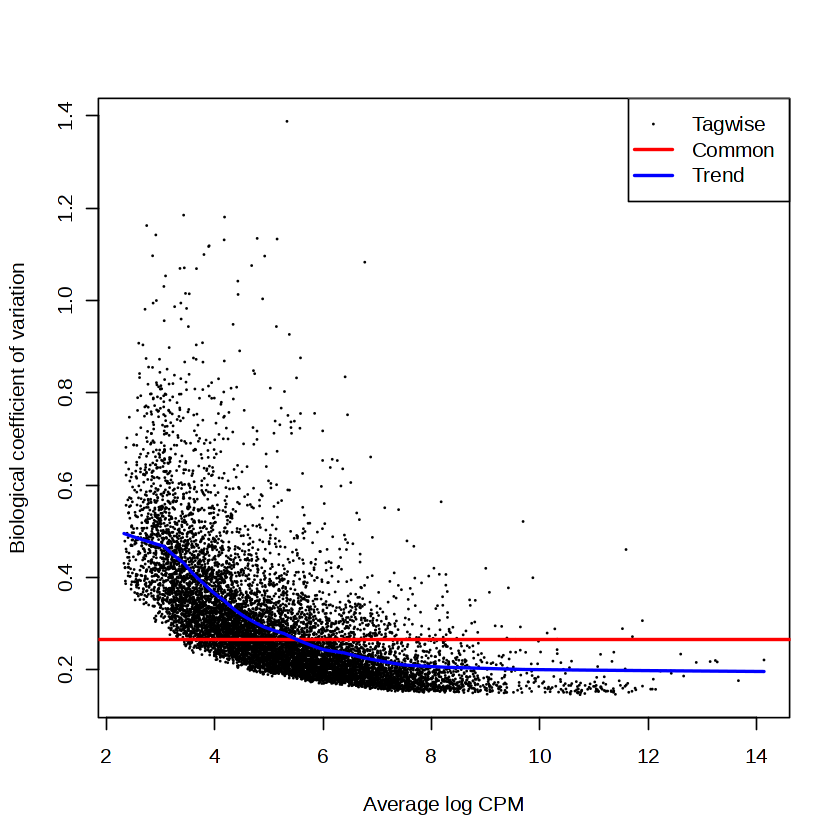

In [46]:
plotBCV(y)

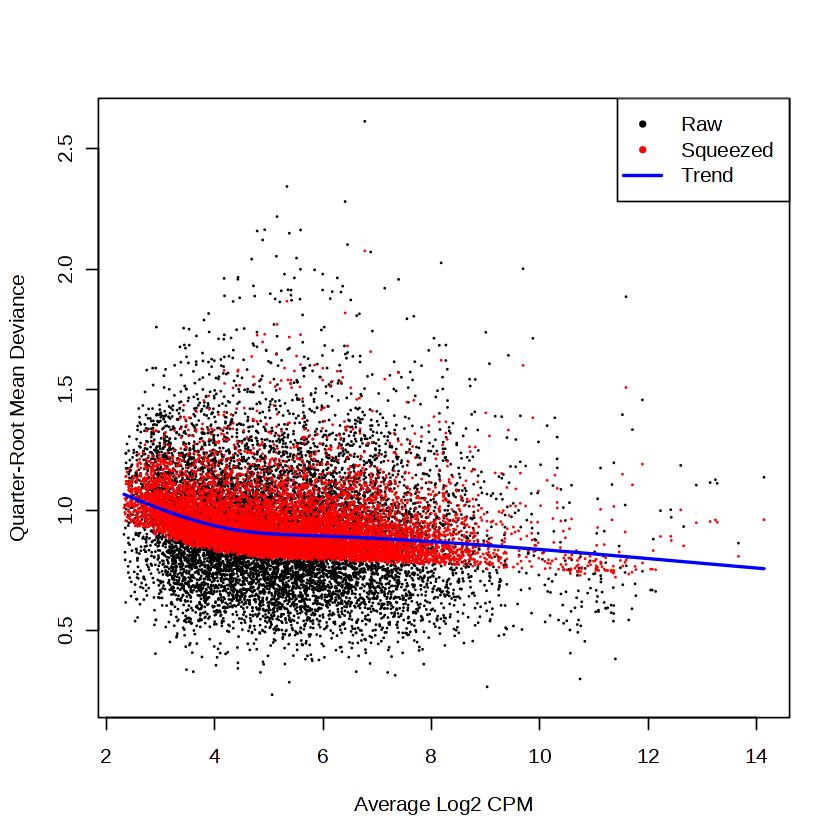

In [47]:
plotQLDisp(fit)

In [48]:
o <- order(qlf$table$PValue)
cpm(y)[o[1:20],]

,Pf-VCT-Hrv232-1,Pf-VCT-Hrv232-2,Pf-VCT-Hrv232-3,UI-VCT-Hrv232-1,UI-VCT-Hrv232-2,UI-VCT-Hrv232-3,UI-VCT-Hrv236-1
MARCH3,8.25877,3.555459,4.981275,53.00890,47.690571,47.94054,29.92416
CTAG2,0.00000,0.000000,0.000000,39.75667,36.851805,92.73745,0.00000
TNFRSF1B,115.62278,119.700458,192.277196,21.20356,9.754889,31.43642,0.00000
GSTM3,8.25877,3.555459,5.977529,31.80534,48.774447,36.93780,0.00000
TGFBR3,187.88702,193.179947,168.367078,65.37764,82.374622,80.94879,44.88623
NHSL1,499.65558,539.244637,435.363391,257.97664,149.574972,186.26080,67.32935
RPS27,1092.22232,1071.378356,1146.689390,1737.80839,2020.345995,2122.74442,3104.63113
SLC7A8,115.62278,131.551988,59.775294,26.50445,31.432422,23.57732,22.44312
TMSB10,766.00091,572.428922,794.015156,1303.13542,1506.588483,1405.20808,209.46909
RPLP2,1604.26606,1439.960954,1760.382409,2591.25166,2912.376442,2822.99073,1817.89245


In [49]:
summary(decideTests(qlf))

       summed_celltype$infectionPf
Down                             1
NotSig                       10392
Up                               0

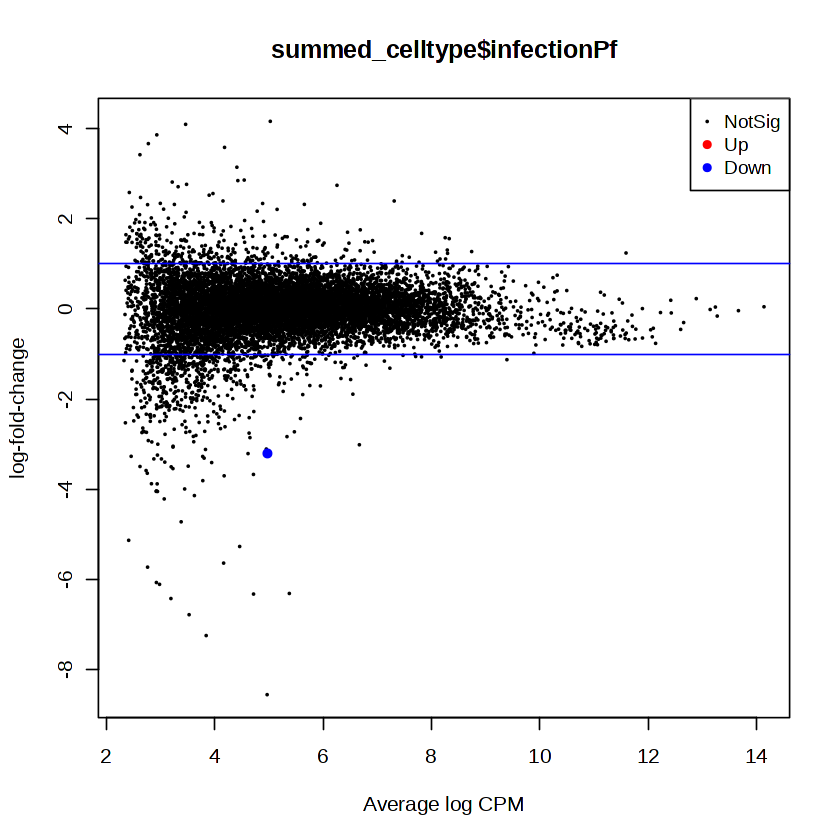

In [50]:
plotMD(qlf)
abline(h=c(-1, 1), col="blue")

In [51]:
limma_de = qlf$table
limma_de$p.adjust = p.adjust(limma_de$PValue, "bonferroni")
limma_de$BH = p.adjust(limma_de$PValue, "BH")

hist(tt$PValue)

ERROR: Error in hist(tt$PValue): object 'tt' not found


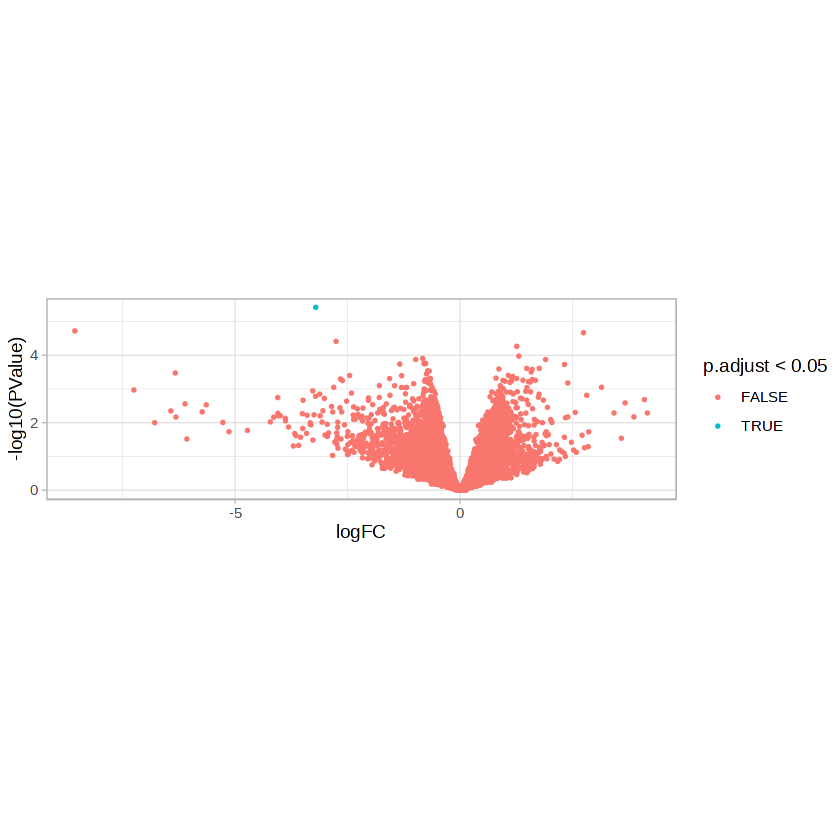

In [52]:
library(ggplot2, warn.conflicts = FALSE)
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = p.adjust < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

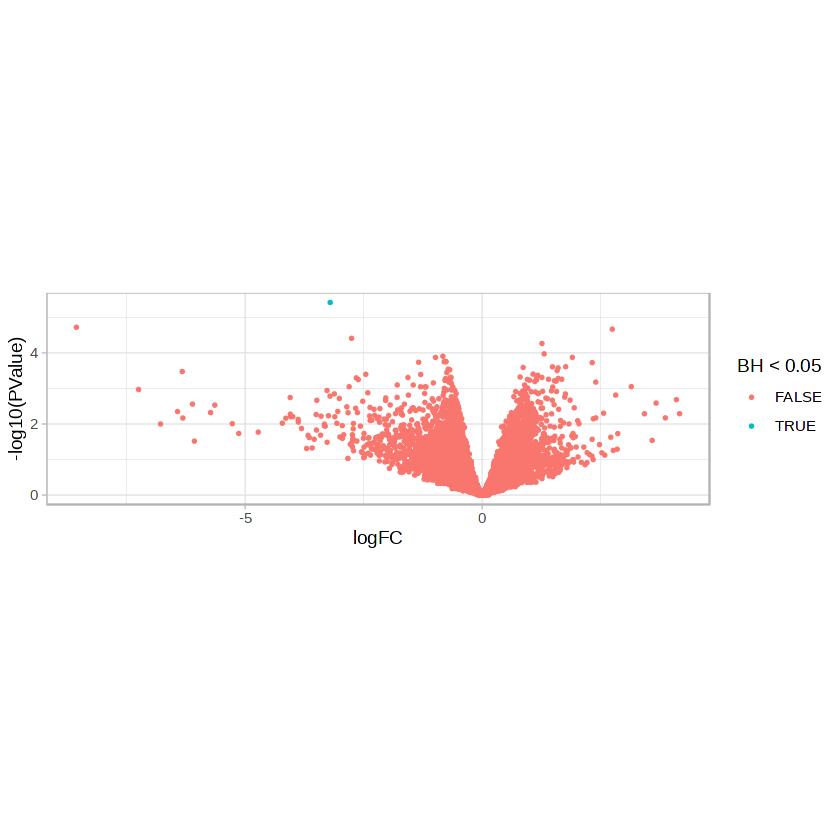

In [53]:
ggplot(limma_de, aes(x = logFC, y = - log10(PValue))) +
  geom_point(aes(color = BH < 0.05), size = 0.5) + 
    theme_light()  + 
    coord_fixed(ratio = 0.75)

In [2]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] magrittr_2.0.3              reshape2_1.4.4             
 [3] edgeR_3.32.1                SeuratObject_4.0.0         
 [5] Seurat_4.0.1                patchwork_1.1.1            
 [7] dplyr_1.0.5                 scran_1.18.5               
